In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, Flatten, BatchNormalization, Conv2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import os

# Path dataset
test_folder = "test"
train_folder = "train"
valid_folder = "valid"

# Result path
result_path = f"run"
os.makedirs(result_path, exist_ok=True)

checkpoint_path = os.path.join(result_path, "best_model.h5")
loss_image_path = os.path.join(result_path, 'validation loss.png')
acc_image_path = os.path.join(result_path, 'validation accuracy.png')

#### Hyperparameter
image_size = (224, 224)
batch_size = 64
epochs = 50
learning_rate = 0.001

#https://www.kaggle.com/datasets/gpiosenka/sports-classification/code
# Load the CSV file
df = pd.read_csv('sports.csv')

# Filter based on the data set column
train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

# Extract filepaths and labels
X_train_paths = train_df['filepaths'].values
y_train_labels = train_df['class id'].values
X_val_paths = valid_df['filepaths'].values
y_val_labels = valid_df['class id'].values
X_test_paths = test_df['filepaths'].values
y_test_labels = test_df['class id'].values

# Assuming y_train_labels and y_val_labels are your labels and num_classes is the number of classes.
y_train = to_categorical(y_train_labels, num_classes=100)
y_val = to_categorical(y_val_labels, num_classes=100)
y_test = to_categorical(y_test_labels, num_classes=100)

# Function to load and preprocess each image
def load_and_preprocess_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img /= 255.0  # normalize to [0,1] range
    return img, label

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
train_dataset = train_dataset.map(load_and_preprocess_image)
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val))
val_dataset = val_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test))
test_dataset = test_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.batch(batch_size)



In [2]:
# import os

# # Starting directory
# root_dir = 'train'


# # List to store paths of non-JPG images
# non_jpg_images = []

# # Traverse through all directories and subdirectories
# for dirpath, dirnames, filenames in os.walk(root_dir):
#     for filename in filenames:
#         # Get file extension
#         _, ext = os.path.splitext(filename)
#         # Check if the file extension is not '.jpg'
#         if ext.lower() not in ['.jpg', '.jpeg']:  # including '.jpeg' just in case
#             non_jpg_path = os.path.join(dirpath, filename)
#             non_jpg_images.append(non_jpg_path)
#             print(f'Non-JPG Image Found: {non_jpg_path}')

# # If you want to save non_jpg_images to a file
# with open('non_jpg_images.txt', 'w') as f:
#     for path in non_jpg_images:
#         f.write(f'{path}\n')


In [3]:
class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Ensure the weight is the same shape as the last dimension of the input
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):    
        h1_x = self.h1(x)
        return (2 * x * h1_x) - 2


class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2

    def call(self, x):
        h1_x = self.h1(x)
        h2_x = self.h2(x)
        return (2 * x * h2_x) - (4 * h1_x)


class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        h2_x = self.h2(x)
        h3_x = self.h3(x)
        return (2 * x * h3_x) - (6 * h2_x)


class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer, self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self, x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))


class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer, self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self, x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))


class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

# N = 2

In [4]:

# def build_model(input_shape, filters):
#     rank = 3
#     input_layer = Input(shape=input_shape)
#     x = input_layer

#     h1 = H1Layer()
#     h2 = H2Layer(h1)
#     x = Dense(filters)(x)
#     x = h2(x)
#     x = Dense(filters)(x)
#     x = Flatten()(x)

#     x = TensorDecompositionLayer(rank)(x)

#     output_layer = Dense(100, activation='softmax')(x)
#     model = Model(inputs=input_layer, outputs=output_layer)

#     return model


# input_shape =  (224, 224, 3)  # Assuming the images are RGB
# filters = 64
# modelN2 = build_model(input_shape, filters)
# optimizer = Adam(learning_rate=learning_rate)  # Reduce learning rate
# modelN2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# history = modelN2.fit(train_dataset,
#                       batch_size=batch_size,
#                       epochs=epochs,
#                       #verbose=0,
#                       validation_data=val_dataset,)
#                       #callbacks=[checkpoint_callback])


# # Plot training history
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
# plt.title('Validation Loss')
# plt.savefig(loss_image_path)

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.legend()
# plt.title('Validation Accuracy')
# plt.savefig(acc_image_path)

# plt.tight_layout()
# plt.show()


# N = 4

In [10]:

def build_model(input_shape, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    
    #First block
    x = Conv2D(filters,(3,3), padding='same')(x)
    x = h2(x)
    x = Conv2D(filters,(3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    #Second block
    x = Conv2D(filters,(3,3), padding='same')(x)
    x = h3(x)
    x = Conv2D(filters,(3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    #Third block
    x = Conv2D(filters,(3,3), padding='same')(x)
    x = h4(x)
    x = Conv2D(filters,(3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    #Output block
    x = Conv2D(filters,(3,3), padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)

    output_layer = Dense(100, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (224,224,3)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 h2_layer_3 (H2Layer)        (None, 224, 224, 64)      64        
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                         

Epoch 1/50


211/211 [==============================] - 52s 211ms/step - loss: 4.7066 - accuracy: 0.0025 - val_loss: 5.5096 - val_accuracy: 0.0100
Epoch 2/50
211/211 [==============================] - 41s 193ms/step - loss: 4.6155 - accuracy: 0.0030 - val_loss: 8.9838 - val_accuracy: 0.0100
Epoch 3/50
211/211 [==============================] - 41s 192ms/step - loss: 4.6067 - accuracy: 0.0049 - val_loss: 63.5091 - val_accuracy: 0.0100
Epoch 4/50
211/211 [==============================] - 41s 194ms/step - loss: 4.6047 - accuracy: 0.0033 - val_loss: 18.7136 - val_accuracy: 0.0100
Epoch 5/50
211/211 [==============================] - 41s 193ms/step - loss: 4.6032 - accuracy: 0.0077 - val_loss: 195.2827 - val_accuracy: 0.0100
Epoch 6/50
211/211 [==============================] - 41s 194ms/step - loss: 4.5981 - accuracy: 0.0070 - val_loss: 2893.8210 - val_accuracy: 0.0100
Epoch 7/50
211/211 [==============================] - 41s 195ms/step - loss: 4.5935 - accuracy: 0.0189 - val_loss: 4456262.5000 - val_

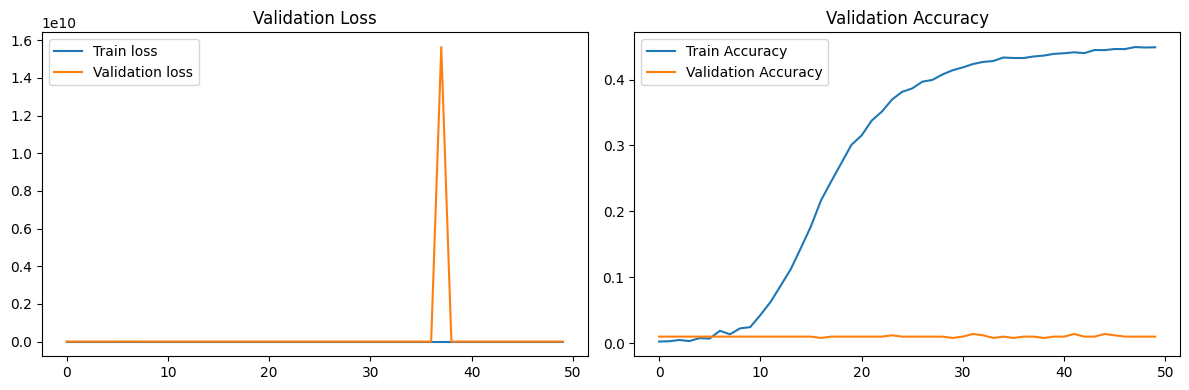

In [11]:
optimizer = Adam(learning_rate=learning_rate) # Reduce learning rate
# modelN4.summary()
modelN4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = modelN4.fit(train_dataset,
                    batch_size=batch_size,
                    epochs=epochs,
                    #verbose=1,
                    validation_data=val_dataset)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Validation Loss')
plt.savefig(loss_image_path)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.savefig(acc_image_path)

plt.tight_layout()
plt.show()



In [ ]:
# import matplotlib.pyplot as plt
# import os
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.applications import MobileNetV2 
# from keras.preprocessing.image import ImageDataGenerator
# import time

In [ ]:
# # Path dataset
# test_folder = "test"
# train_folder = "train"
# valid_folder = "valid"

# ## Result path
# result_path = f"run"
# os.makedirs(result_path, exist_ok=True)

# checkpoint_path = os.path.join(result_path, "best_model.h5")
# loss_image_path = os.path.join(result_path, 'validation loss.png')
# acc_image_path = os.path.join(result_path, 'validation accuracy.png')

In [ ]:
# #### Hyperparameter
# image_size = (224, 224)
# batch_size = 32
# epochs = 50
# learning_rate = 0.0001
# train_datagen = ImageDataGenerator(
#                     rescale = 1./255,
#                     rotation_range = 30,
#                     shear_range=0.3,
#                     zoom_range=0.3,
#                     horizontal_flip=True,
#                     fill_mode='nearest')

# val_test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(train_folder,
#                                                     target_size=image_size,
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical',
#                                                     shuffle=True)


# val_generator = val_test_datagen.flow_from_directory(valid_folder,
#                                                  target_size=image_size,
#                                                  batch_size=batch_size,
#                                                  class_mode='categorical',
#                                                  shuffle=True)

# test_generator = val_test_datagen.flow_from_directory(test_folder,
#                                                  target_size=image_size,
#                                                  batch_size=batch_size,
#                                                  class_mode='categorical',
#                                                  shuffle=True)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
# # Membuat model MobileNet
# base_model = MobileNetV2(
#     weights='imagenet', 
#     include_top=False, 
#     input_shape=(image_size[0], image_size[1], 3),
# )

# for layer in base_model.layers[:-10]:
#     layer.trainable = False

# x = base_model.output
# x = Flatten()(x)
# x = Dense(512, activation='relu',  kernel_regularizer='l2')(x)
# predictions = Dense(100, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# # callbacks
# model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# # Hitung waktu training
# start_time = time.time()

# # Latih model dengan menggunakan model checkpoint
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data = val_generator,
#     callbacks=[model_checkpoint, early_stopping],
#     batch_size = batch_size,
# )

# # Hitung waktu training
# end_time = time.time()

Epoch 1/10


2023-10-12 13:03:51.639138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-12 13:03:52.180861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-12 13:03:52.182608: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd7ca136ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 13:03:52.182620: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-12 13:03:52.185821: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 13:03:52.288010: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

938/938 [==============================] - 8s 5ms/step - loss: 0.8676 - accuracy: 0.6802 - val_loss: 0.2864 - val_accuracy: 0.9289
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2212 - accuracy: 0.9403 - val_loss: 0.1728 - val_accuracy: 0.9533
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1035 - accuracy: 0.9694 - val_loss: 0.0920 - val_accuracy: 0.9753
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0781 - accuracy: 0.9769 - val_loss: 0.0834 - val_accuracy: 0.9785
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0556 - accuracy: 0.9829 - val_loss: 0.1137 - val_accuracy: 0.9744
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0666 - accuracy: 0.9803 - val_loss: 0.0901 - val_accuracy: 0.9787
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0359 - accuracy: 0.9885 - val_loss: 0.1245 - val_accuracy: 0.9698
Epoch 8/10
938/93

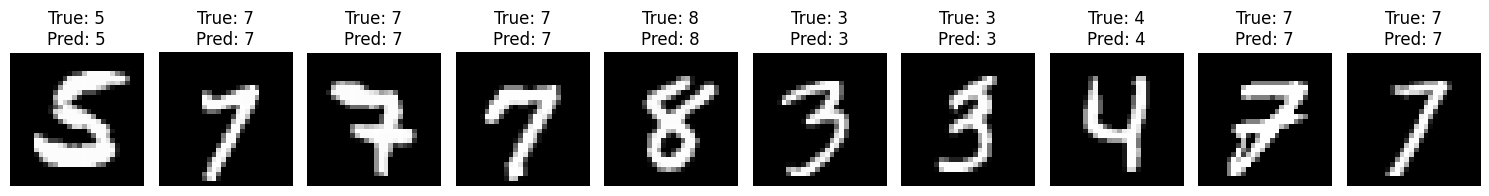

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)


def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Conv2D(filters, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    
    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1, h2)
    h4 = H4Layer(h2, h3)
    
    x = h2(x)
    x = Dense(128)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(128)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(64)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(10, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 

# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (28, 28, 1)
filters = 64
model_mnist = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 64
epochs = 10

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()


2023-10-05 16:25:16.850955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 16:25:17.384073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-05 16:25:18.532870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 16:25:18.547917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Epoch 1/10


2023-10-05 16:25:21.648890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 16:25:22.146879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-05 16:25:22.228591: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e5a8220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 16:25:22.228621: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-05 16:25:22.234742: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 16:25:22.329757: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 8s 5ms/step - loss: 2.0337 - accuracy: 0.1756 - val_loss: 1.8398 - val_accuracy: 0.2304
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 1.7220 - accuracy: 0.2985 - val_loss: 1.6635 - val_accuracy: 0.3355
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 1.5701 - accuracy: 0.3888 - val_loss: 1.5344 - val_accuracy: 0.4047
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 1.4649 - accuracy: 0.4425 - val_loss: 1.5072 - val_accuracy: 0.4239
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 1.3609 - accuracy: 0.4882 - val_loss: 1.3796 - val_accuracy: 0.4637
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 1.2653 - accuracy: 0.5322 - val_loss: 1.3327 - val_accuracy: 0.4888
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 1.1798 - accuracy: 0.5693 - val_loss: 1.3165 - val_accuracy: 0.5436
Epoch 8/10
782/78

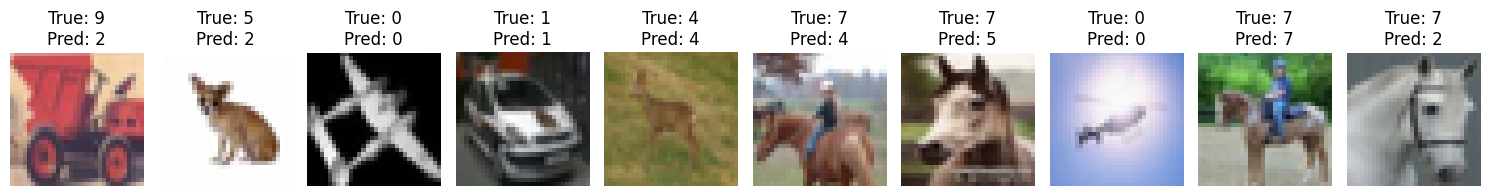

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)


def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Conv2D(filters, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1, h2)
    h4 = H4Layer(h2, h3)
    
    x = h2(x)
    x = Dense(128, activation='relu')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(128, activation='relu')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(64, activation='relu')(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(10, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 
# Load and preprocess the CIFAR-10 data
(X_train, y_train), (X_val, y_val) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (32, 32, 3)  # CIFAR-10 images are 32x32 RGB images
filters = 64
model_cifar = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001)
model_cifar.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 10

history = model_cifar.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_cifar.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_cifar.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i])
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()


2023-10-12 15:12:30.772762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:12:31.323331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-12 15:12:41.445879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 15:12:41.469600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Epoch 1/50


2023-10-12 15:12:44.041838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-12 15:12:44.043885: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58966b02e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 15:12:44.043896: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-12 15:12:44.046987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 15:12:44.154318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-12 15:12:44.247071: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

782/782 [==============================] - 6s 4ms/step - loss: 2.2931 - accuracy: 0.1181 - val_loss: 2.2384 - val_accuracy: 0.1373
Epoch 2/50
782/782 [==============================] - 3s 4ms/step - loss: 2.1824 - accuracy: 0.1694 - val_loss: 2.1402 - val_accuracy: 0.1750
Epoch 3/50
782/782 [==============================] - 3s 4ms/step - loss: 2.1146 - accuracy: 0.1831 - val_loss: 2.0674 - val_accuracy: 0.1990
Epoch 4/50
782/782 [==============================] - 3s 4ms/step - loss: 2.0150 - accuracy: 0.2117 - val_loss: 1.9806 - val_accuracy: 0.2342
Epoch 5/50
782/782 [==============================] - 3s 4ms/step - loss: 1.9244 - accuracy: 0.2451 - val_loss: 1.8691 - val_accuracy: 0.2683
Epoch 6/50
782/782 [==============================] - 3s 4ms/step - loss: 1.8761 - accuracy: 0.2631 - val_loss: 1.8559 - val_accuracy: 0.2730
Epoch 7/50
782/782 [==============================] - 3s 4ms/step - loss: 1.8400 - accuracy: 0.2764 - val_loss: 1.8043 - val_accuracy: 0.3066
Epoch 8/50
782/78

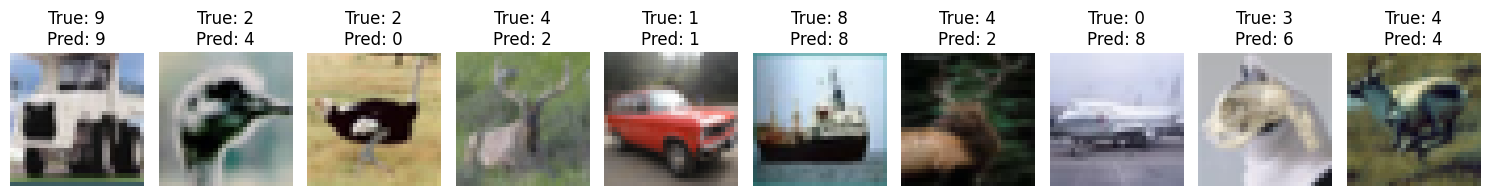

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D,BatchNormalization,Add,Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA



class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)


def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Dense(256)(x)
    x = Dropout(0.25)(x)  # Added dropout here
    
    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1, h2)
    h4 = H4Layer(h2, h3)
    
    x = h2(x)
    x = Dense(256)(x)
    x = Dropout(0.25)(x)  # Added dropout here
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(256)(x)
    x = Dropout(0.25)(x)  # Added dropout here

    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(64)(x)
    x = Dropout(0.25)(x)  # Added dropout here

    
    x = TensorDecompositionLayer(rank)(x)

    
    output_layer = Dense(10, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the CIFAR-10 data
(X_train, y_train), (X_val, y_val) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

# Flatten the data for PCA
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))

# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Reshape to 2D for Dense layer input
X_train_pca = X_train_pca.reshape((X_train.shape[0], n_components)) # ADDED PCA
X_val_pca = X_val_pca.reshape((X_val.shape[0], n_components))

#input_shape = (32, 32, 3)  # CIFAR-10 images are 32x32 RGB images
input_shape = (n_components, ) #PCA UPDATED INPUT SHAPE
filters = 64
model_cifar = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) #MODIFIED LEARNING RATE
model_cifar.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 50

history = model_cifar.fit(X_train_pca, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val_pca, y_val))

val_loss, val_acc = model_cifar.evaluate(X_val_pca, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")
# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples_original = X_val[indices]  # original images for visualization
X_test_samples_pca = X_val_pca[indices]   # PCA-transformed data for prediction
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_cifar.predict(X_test_samples_pca), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples_original[i])
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()


# Deeper Arch for colored images

2023-10-12 13:49:14.567077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:49:15.154633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-12 13:49:16.436513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 13:49:16.455067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Epoch 1/50


2023-10-12 13:49:19.223649: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-12 13:49:20.113029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-12 13:49:20.687835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-12 13:49:20.689867: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f213400d910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 13:49:20.689912: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-12 13:49:20.696091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] di

782/782 [==============================] - 14s 12ms/step - loss: 2.6325 - accuracy: 0.1072 - val_loss: 2.3177 - val_accuracy: 0.1113
Epoch 2/50
782/782 [==============================] - 9s 11ms/step - loss: 2.0820 - accuracy: 0.2031 - val_loss: 2.1257 - val_accuracy: 0.1969
Epoch 3/50
782/782 [==============================] - 9s 11ms/step - loss: 1.7712 - accuracy: 0.3302 - val_loss: 2.0615 - val_accuracy: 0.2315
Epoch 4/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5305 - accuracy: 0.4327 - val_loss: 2.0259 - val_accuracy: 0.2680
Epoch 5/50
782/782 [==============================] - 9s 11ms/step - loss: 1.3896 - accuracy: 0.4936 - val_loss: 1.8383 - val_accuracy: 0.3089
Epoch 6/50
782/782 [==============================] - 9s 11ms/step - loss: 1.2896 - accuracy: 0.5363 - val_loss: 1.7014 - val_accuracy: 0.3841
Epoch 7/50
782/782 [==============================] - 9s 11ms/step - loss: 1.2076 - accuracy: 0.5688 - val_loss: 1.5270 - val_accuracy: 0.4553
Epoch 8/5

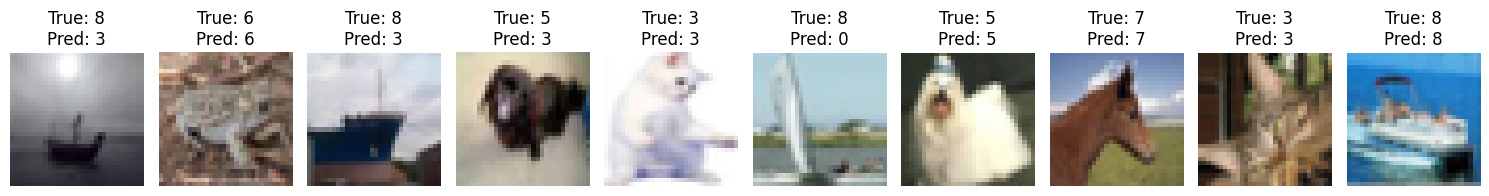

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)


def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    # First Conv Block
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(0.25)(x)  # Added dropout here
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)


    # Second Conv Block
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(0.25)(x)  # Added dropout here
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Third Conv Block
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(0.25)(x)  # Added dropout here
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    
    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1, h2)
    h4 = H4Layer(h2, h3)
    
    x = h2(x)
    x = Dense(128)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(128)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(64)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(10, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 
# Load and preprocess the CIFAR-10 data
(X_train, y_train), (X_val, y_val) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (32, 32, 3)  # CIFAR-10 images are 32x32 RGB images
filters = 64
model_cifar = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001)
model_cifar.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 50

history = model_cifar.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_cifar.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_cifar.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i])
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()
